# Data Analysis

## **Question 1**
What is the geographical distribution of listings, room types, and price levels across Bangkok's neighborhoods? Are there specific neighborhoods with a high concentration of certain room types, and how does this correlate with popularity (number of reviews) and price?

* * *

**Why is it important?**

The answer to this question will provide a clear visual map of the Airbnb market in Bangkok.
For Airbnb, it helps identify underserved areas for growth strategies. For investors and hosts, it highlights premium locations and investment opportunities based on the most popular property types in specific areas.

* Location is the main determining factor in the accommodation industry.
* Stakeholders (Airbnb, hosts, investors, local governments) need to know if there is certain clustering, for example neighborhoods dominated only by premium “entire homes” or backpacker areas with many “shared rooms.”
* Correlation with popularity (reviews) and price helps shape promotion strategies & market segmentation.


* * *

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import normaltest, chi2_contingency, mannwhitneyu, ttest_ind

import warnings
warnings.filterwarnings("ignore")

### --- 1) Geo scatter: Listing Distribution ---

In [ ]:
# --- Load ---
df = pd.read_csv("Airbnb Bangkok Listings (clean).csv", parse_dates=["last_review"])

In [ ]:
price_bands = df.groupby("neighbourhood")["price"].agg(
    median="median",
    p25=lambda x: x.quantile(0.25),
    p75=lambda x: x.quantile(0.75)
).reset_index()

price_bands["price_band"] = pd.qcut(price_bands["median"], q=3, labels=["Low", "Medium", "High"])

df = df.merge(price_bands[["neighbourhood","price_band"]], on="neighbourhood", how="left")

In [ ]:
print(df.columns)
df["price_band"].value_counts()

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'has_review', 'price_before', 'price_after',
       'occupancy_rate', 'days_since_last_review', 'host_tier', 'price_band'],
      dtype='object')


,count
price_band,
High,9242
Low,3568
Medium,3044


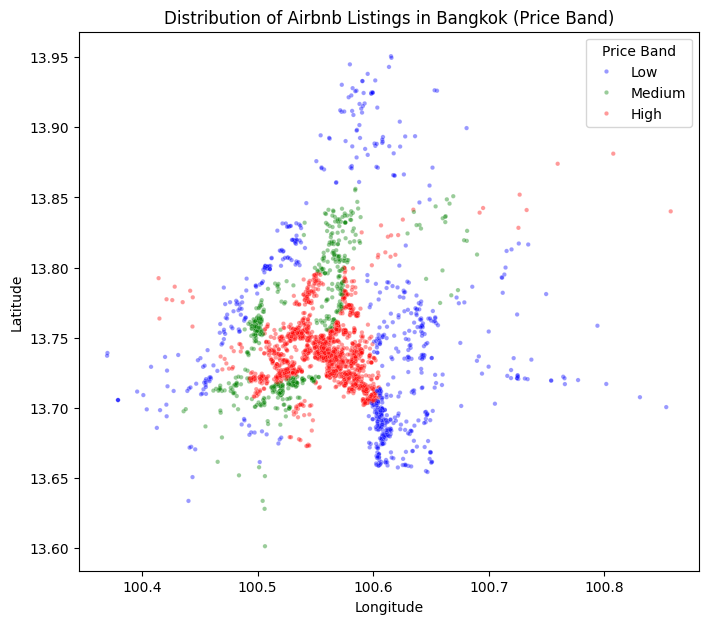

In [ ]:
plt.figure(figsize=(8,7))
sns.scatterplot(
    x="longitude", y="latitude",
    hue="price_band", data=df.sample(3000, random_state=42),
    alpha=0.4, s=10,
    palette={"High": "red", "Low": "blue", "Medium": "green"}  # custom mapping
)
plt.title("Distribution of Airbnb Listings in Bangkok (Price Band)")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.legend(title="Price Band")
plt.show()

In [ ]:
import folium

# Bangkok city center
bangkok_center = [13.7563, 100.5018]

# Create the base map
m = folium.Map(location=bangkok_center, zoom_start=11)

# Add listing points (sample 2000 to avoid overloading)
for _, row in df.sample(2000, random_state=42).iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=3,
        color="red" if row["price_band"]=="High" else
              "blue" if row["price_band"]=="Low" else "green",
        fill=True, fill_opacity=0.6,
        popup=folium.Popup(
            f"""
            <b>Neighbourhood:</b> {row['neighbourhood']}<br>
            <b>Price:</b> {row['price']}<br>
            <b>Room Type:</b> {row['room_type']}
            """,
            max_width=250
        )
    ).add_to(m)

# Save the map ✅
m.save("Bangkok airbnb map.html")
print("Interactive map with popup saved as: bangkok_airbnb_map_popup.html")

Interactive map with popup saved as: bangkok_airbnb_map_popup.html


### --- 2) Crosstab: neighbourhood × room_type

In [ ]:
ct = pd.crosstab(df["neighbourhood"], df["room_type"])
ct_pct = (ct.div(ct.sum(axis=1), axis=0) * 100).round(2)

# focus on top-20 neighbourhoods by count
top_neigh = df["neighbourhood"].value_counts().head(20).index
ct_top = ct.loc[top_neigh]
ct_pct_top = ct_pct.loc[top_neigh]

# Display results
print("Count table:")
display(ct_top)

print("\nPercentage table (%):")
display(ct_pct_top)

Count table:


room_type,Entire home/apt,Hotel room,Private room,Shared room
neighbourhood,,,,
Vadhana,1451,105,544,53
Khlong Toei,1520,73,489,15
Huai Khwang,776,25,301,23
Ratchathewi,656,70,327,61
Bang Rak,351,67,375,34
Sathon,557,15,220,17
Phra Nakhon,56,77,355,131
Phra Khanong,336,9,201,12
Chatu Chak,273,2,266,7



Percentage table (%):


room_type,Entire home/apt,Hotel room,Private room,Shared room
neighbourhood,,,,
Vadhana,67.39,4.88,25.27,2.46
Khlong Toei,72.48,3.48,23.32,0.72
Huai Khwang,68.98,2.22,26.76,2.04
Ratchathewi,58.89,6.28,29.35,5.48
Bang Rak,42.44,8.10,45.34,4.11
Sathon,68.85,1.85,27.19,2.10
Phra Nakhon,9.05,12.44,57.35,21.16
Phra Khanong,60.22,1.61,36.02,2.15
Chatu Chak,49.82,0.36,48.54,1.28


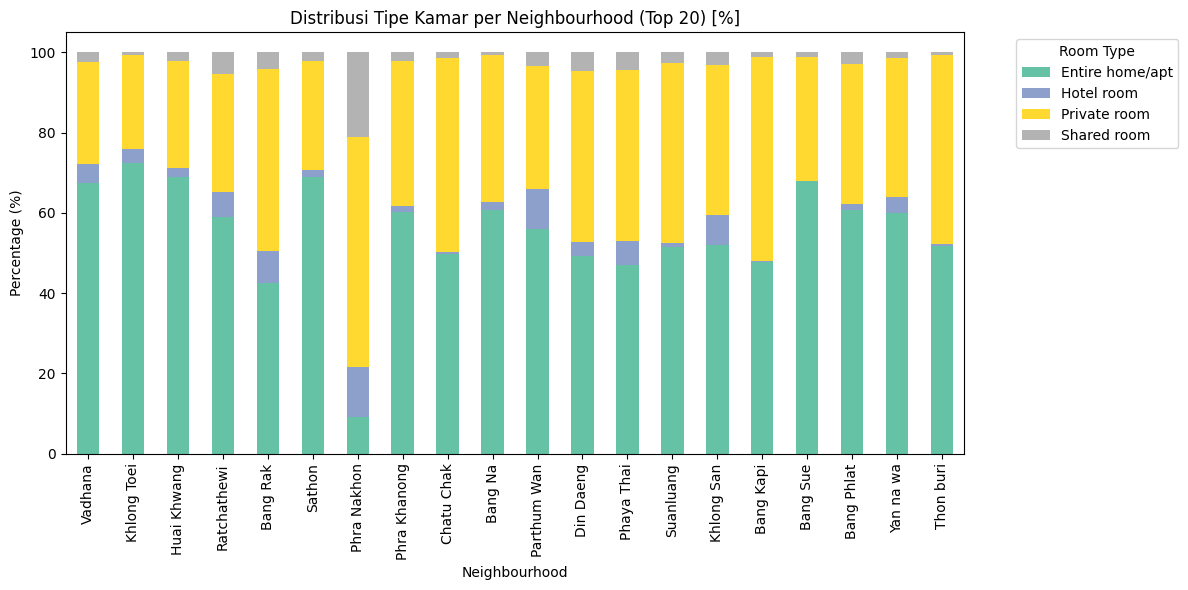

In [ ]:
# Plot stacked bar chart
ct_pct_top.plot(kind="bar", stacked=True, figsize=(12,6), colormap="Set2")

plt.title("Distribusi Tipe Kamar per Neighbourhood (Top 20) [%]")
plt.xlabel("Neighbourhood")
plt.ylabel("Percentage (%)")
plt.legend(title="Room Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

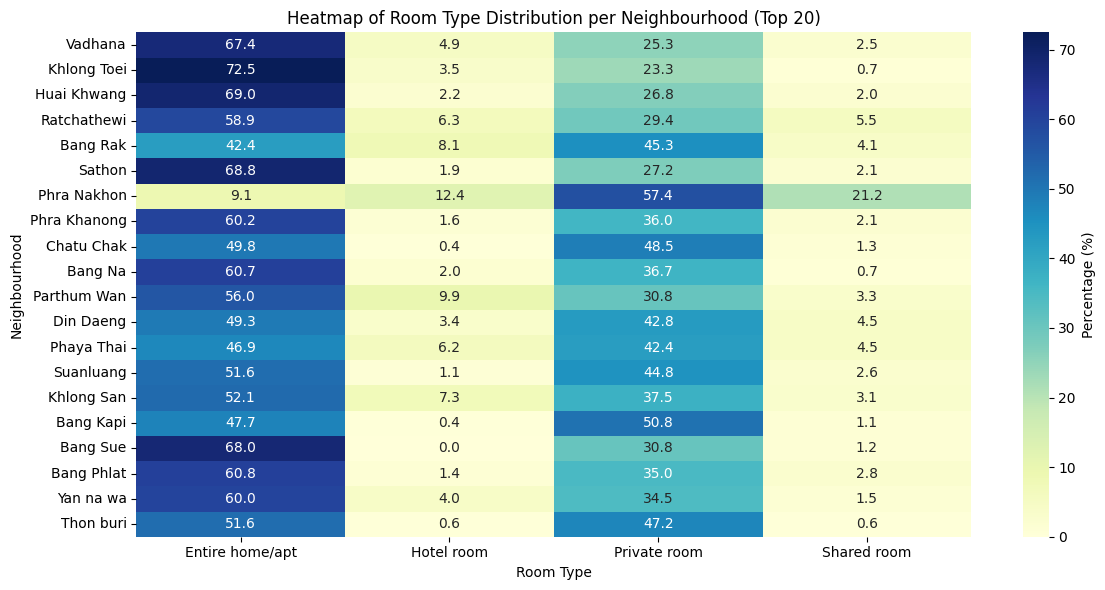

In [ ]:
# summary

plt.figure(figsize=(12,6))
sns.heatmap(ct_pct_top, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Percentage (%)'})

plt.title("Heatmap of Room Type Distribution per Neighbourhood (Top 20)")
plt.xlabel("Room Type")
plt.ylabel("Neighbourhood")
plt.tight_layout()
plt.show()

### --- 3) Price differences across neighborhoods (Kruskal + informative ANOVA) —

In [ ]:
from scipy import stats

# Filter neighbourhoods with ≥ 30 listings
valid_neigh = df["neighbourhood"].value_counts()
valid_neigh = valid_neigh[valid_neigh >= 30].index
groups = [df.loc[df["neighbourhood"] == n, "price"].dropna() for n in valid_neigh]

# Kruskal-Wallis test (non-parametric)
kruskal_stat, kruskal_p = stats.kruskal(*groups)

# Classical ANOVA (only as additional info)
try:
    anova_stat, anova_p = stats.f_oneway(*groups)
except Exception:
    anova_stat, anova_p = np.nan, np.nan

# Create result table
anova_table = pd.DataFrame({
    "Test": ["Kruskal-Wallis (robust ANOVA)", "Classical ANOVA (f_oneway)"],
    "Statistic": [kruskal_stat, anova_stat],
    "p_value": [kruskal_p, anova_p]
})

# Format p-values for readability
anova_table["p_value"] = anova_table["p_value"].apply(lambda x: f"{x:.2e}" if x < 1e-16 else round(x,6))

display(anova_table)

,Test,Statistic,p_value
0,Kruskal-Wallis (robust ANOVA),2010.079272,0.00e+00
1,Classical ANOVA (f_oneway),30.437495,9.96e-236


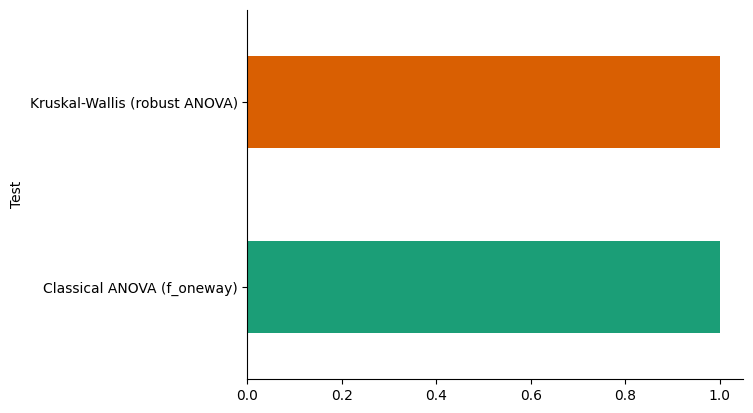

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
anova_table.groupby('Test').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

	1.	Kruskal-Wallis (robust ANOVA, nonparametric)
*	Statistic = 2010.08 → a very large test value.
* p-value = 0.00e+00 (smaller than 1e-16 → practically zero).
* Interpretation: There is a highly significant difference in Airbnb prices across neighborhoods.
* This method does not rely on normality assumptions → results are more reliable for price data (which are usually skewed / have outliers).

	2.	Classical ANOVA (f_oneway,

*   F Statistic = 30.43 → large F value,showing that variation between groups is greater than variation within groups.
*   p-value = 9.96e-236 → extremely small (far < 0.05).
*  Interpretation: Also confirms that prices differ significantly across neighborhoods, although this test is more sensitive to normality assumptions.


⸻

Conclusion as Analyst
* Location (neighborhood) indeed has a strong influence on Airbnb listing prices in Bangkok.
* Not random → the data supports that the Bangkok Airbnb market is segmented by location.
* Since both tests (parametric & non-parametric) are consistent → we can be confident that the conclusion is valid.

⸻

Recommendations to Stakeholders
	1.	For Airbnb (platform):
* Can provide automatic price recommendations (smart pricing) based on neighborhood.
* Create price guides per area to help new hosts set prices according to location.
	2.	For Hosts:
* Don’t just compare prices across the whole Bangkok → compare within the same neighborhood.
* Hosts in premium areas (city center, tourist hubs) can set much higher prices.
* Hosts in suburban areas should compete through value-added (facilities, reviews, etc.), not just by raising prices.
	3.	For Investors:
* Choose neighborhoods based on strategy:
* High price → target higher margin per unit.
* Low/Medium price → target higher booking volume.

### --- 4) Correlation per neighborhood: price vs number_of_reviews (Spearman) —

In [ ]:
rows = []
for g, sub in df.groupby("neighbourhood"):
    if len(sub) >= 30:
        rho, p = stats.spearmanr(sub["price"], sub["number_of_reviews"], nan_policy="omit")
        rows.append([g, len(sub), rho, p])
corr_tbl = pd.DataFrame(rows, columns=["neighbourhood", "n_listings", "spearman_rho", "p_value"])
corr_tbl["abs_rho"] = corr_tbl["spearman_rho"].abs()
corr_tbl = corr_tbl.sort_values("abs_rho", ascending=False)

# show top 10 neighborhoods with the strongest correlations
corr_tbl.head(10)

,neighbourhood,n_listings,spearman_rho,p_value,abs_rho
30,Pom Prap Sattru Phai,123,-0.457296,1.053659e-07,0.457296
32,Rat Burana,53,-0.436777,1.075955e-03,0.436777
17,Khan Na Yao,55,-0.370288,5.390563e-03,0.370288
1,Bang Khae,92,-0.339651,9.252490e-04,0.339651
12,Chom Thong,74,-0.325353,4.676170e-03,0.325353
8,Bangkok Noi,152,-0.311700,9.267585e-05,0.311700
3,Bang Kho laen,140,-0.304988,2.482963e-04,0.304988
43,Yan na wa,200,-0.274168,8.545562e-05,0.274168
35,Samphanthawong,114,-0.255022,6.175430e-03,0.255022
21,Lak Si,126,-0.242682,6.181258e-03,0.242682


### --- 5) Price summary per neighborhood —

In [ ]:
price_summary = df.groupby("neighbourhood")["price"].agg(
    n="count", mean="mean", median="median",
    p25=lambda x: x.quantile(0.25), p75=lambda x: x.quantile(0.75)
).sort_values(by="median", ascending=False)
price_summary.head(10)

,n,mean,median,p25,p75
neighbourhood,,,,,
Nong Chok,14,2939.357143,2539.0,756.25,4015.75
Parthum Wan,455,2904.986813,2400.0,1422.00,3717.00
Samphanthawong,114,2473.859649,2000.0,1150.50,2941.75
Vadhana,2153,2687.392476,2000.0,1290.00,3463.00
Bang Rak,827,2392.600967,1850.0,1100.00,3199.00
Pom Prap Sattru Phai,123,2387.902439,1709.0,969.00,2748.50
Khlong Toei,2097,2227.194087,1700.0,1173.00,2571.00
Ratchathewi,1114,1968.865350,1536.0,1200.00,2500.00
Taling Chan,50,2196.400000,1502.5,1025.00,2599.00


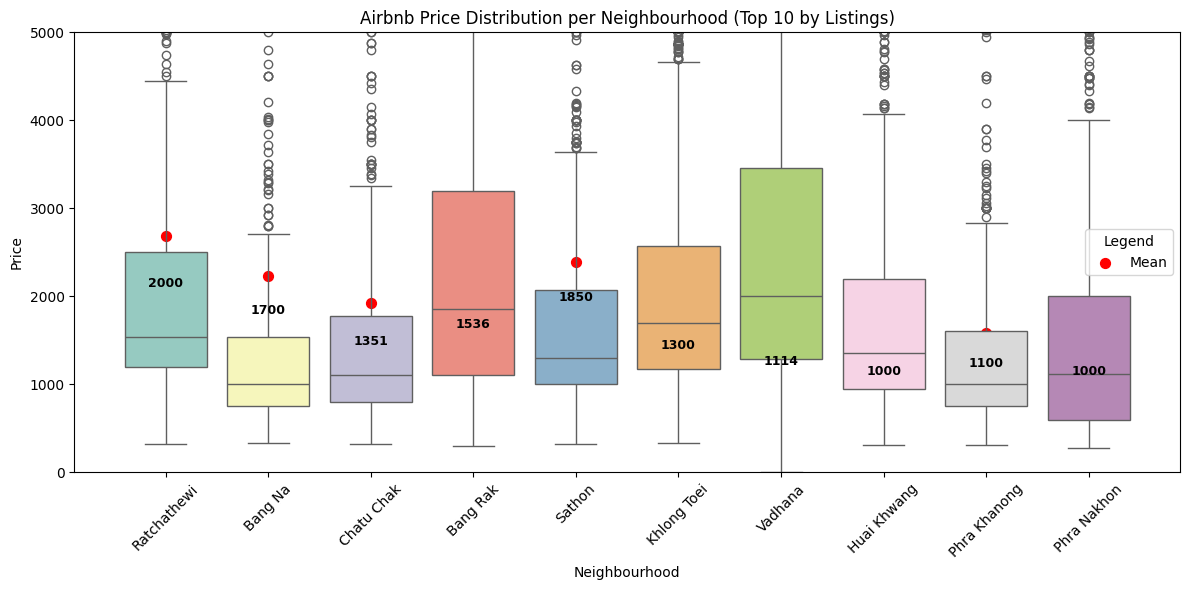

In [ ]:
# Take the 10 neighborhoods with the most listings
top10_neigh = df["neighbourhood"].value_counts().head(10).index
df_top10 = df[df["neighbourhood"].isin(top10_neigh)]

plt.figure(figsize=(12,6))
ax = sns.boxplot(
    x="neighbourhood",
    y="price",
    data=df_top10,
    palette="Set3"
)

# Add mean as red dots
mean_prices = df_top10.groupby("neighbourhood")["price"].mean()
for i, neigh in enumerate(top10_neigh):
    plt.scatter(i, mean_prices[neigh], color="red", marker="o", s=50, label="Mean" if i==0 else "")

# Add median labels above each box
medians = df_top10.groupby("neighbourhood")["price"].median()
for i, neigh in enumerate(top10_neigh):
    median_val = medians[neigh]
    ax.text(i, median_val + 100, f"{int(median_val)}",
            ha='center', color='black', fontsize=9, fontweight='bold')

plt.title("Airbnb Price Distribution per Neighbourhood (Top 10 by Listings)")
plt.xlabel("Neighbourhood")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.ylim(0, 5000)  # limit to reduce noise from extreme outliers
plt.legend(title="Legend")
plt.tight_layout()
plt.show()

  price_band  median_price  avg_reviews
0        Low         965.0     9.911435
1     Medium        1200.0    17.778909
2       High        1685.5    18.886821


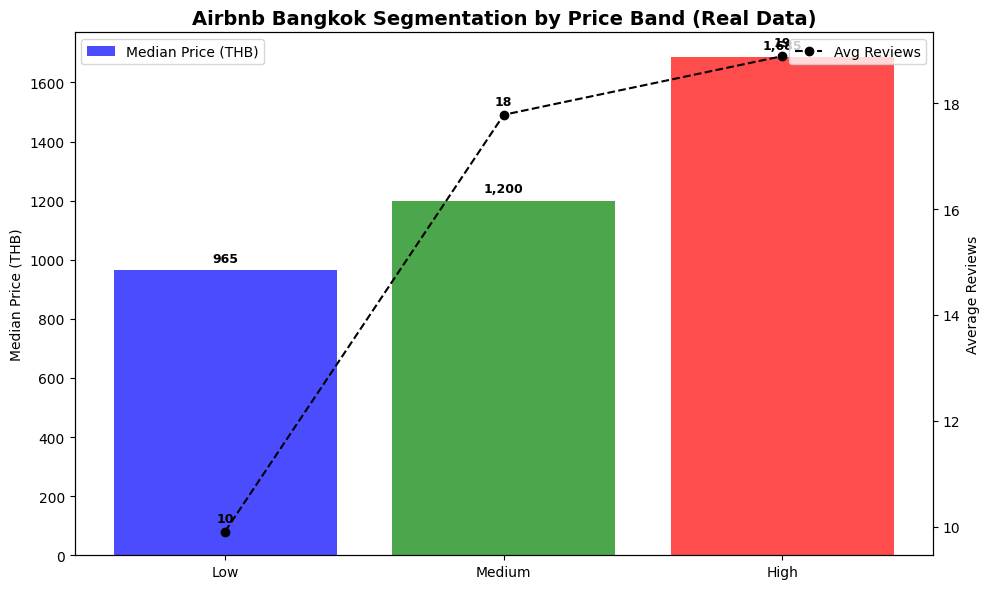

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Summary per band
band_summary = df.groupby("price_band").agg(
    median_price=("price","median"),
    avg_reviews=("number_of_reviews","mean")
).reset_index()

# Ensure order Low→Medium→High
band_summary = band_summary.sort_values("price_band")

print(band_summary)

# Plot
fig, ax = plt.subplots(figsize=(10,6))

bars = ax.bar(band_summary["price_band"], band_summary["median_price"],
              color=["blue","green","red"], alpha=0.7, label="Median Price (THB)")

ax2 = ax.twinx()
line = ax2.plot(band_summary["price_band"], band_summary["avg_reviews"],
                color="black", marker="o", linestyle="--", label="Avg Reviews")

# Label numbers above bars
for bar in bars:
    h = bar.get_height()
    ax.annotate(f'{int(h):,}',
                xy=(bar.get_x()+bar.get_width()/2, h),
                xytext=(0,4), textcoords="offset points",
                ha='center', va='bottom', fontsize=9, fontweight="bold")

# Label numbers at line points
for i, v in enumerate(band_summary["avg_reviews"]):
    ax2.annotate(f'{int(round(v)):,}', xy=(i, v),
                 xytext=(0,5), textcoords="offset points",
                 ha='center', va='bottom', fontsize=9, fontweight="bold")

ax.set_title("Airbnb Bangkok Segmentation by Price Band (Real Data)", fontsize=14, fontweight="bold")
ax.set_ylabel("Median Price (THB)")
ax2.set_ylabel("Average Reviews")

ax.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()

Key Insights:
- High band (Premium Areas): Sukhumvit, Siam → Entire home/apt, high price (>2000 THB), fewer reviews.
- Medium band (Transitional Areas): Mix of room types, mid-price (~1400 THB), moderate reviews.
- Low band (Budget Areas): Bang Kapi, Bang Khae → Private rooms dominate, low price (<1000 THB), many reviews.

Recommendations:
- Hosts: Adjust pricing based on neighborhood peer group, align room type with area demand.
- Airbnb (Platform): Provide smart pricing & room type guides per neighborhood.
- Investors: Choose strategy → Premium = margin, Budget = volume, Medium = growth potential.